In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

experiments = pd.read_parquet("results.parquet")
experiments["error"] = np.abs(experiments["estimate"])

range_ns = np.unique(experiments["n"])
range_deltas = -np.sort(-np.unique(experiments["delta"]))
range_distributions = np.unique(experiments["distribution"])

# organize results
df_grouped = [ experiments[ experiments["delta"] == delta ].groupby(["n", "delta", "method", "distribution"])["error"].quantile(1-delta).reset_index() for delta in range_deltas ]
df_grouped = pd.concat(df_grouped)

df_grouped # = df_grouped[ df_grouped.method.isin(["atm", "lv", "quarter"]) ]

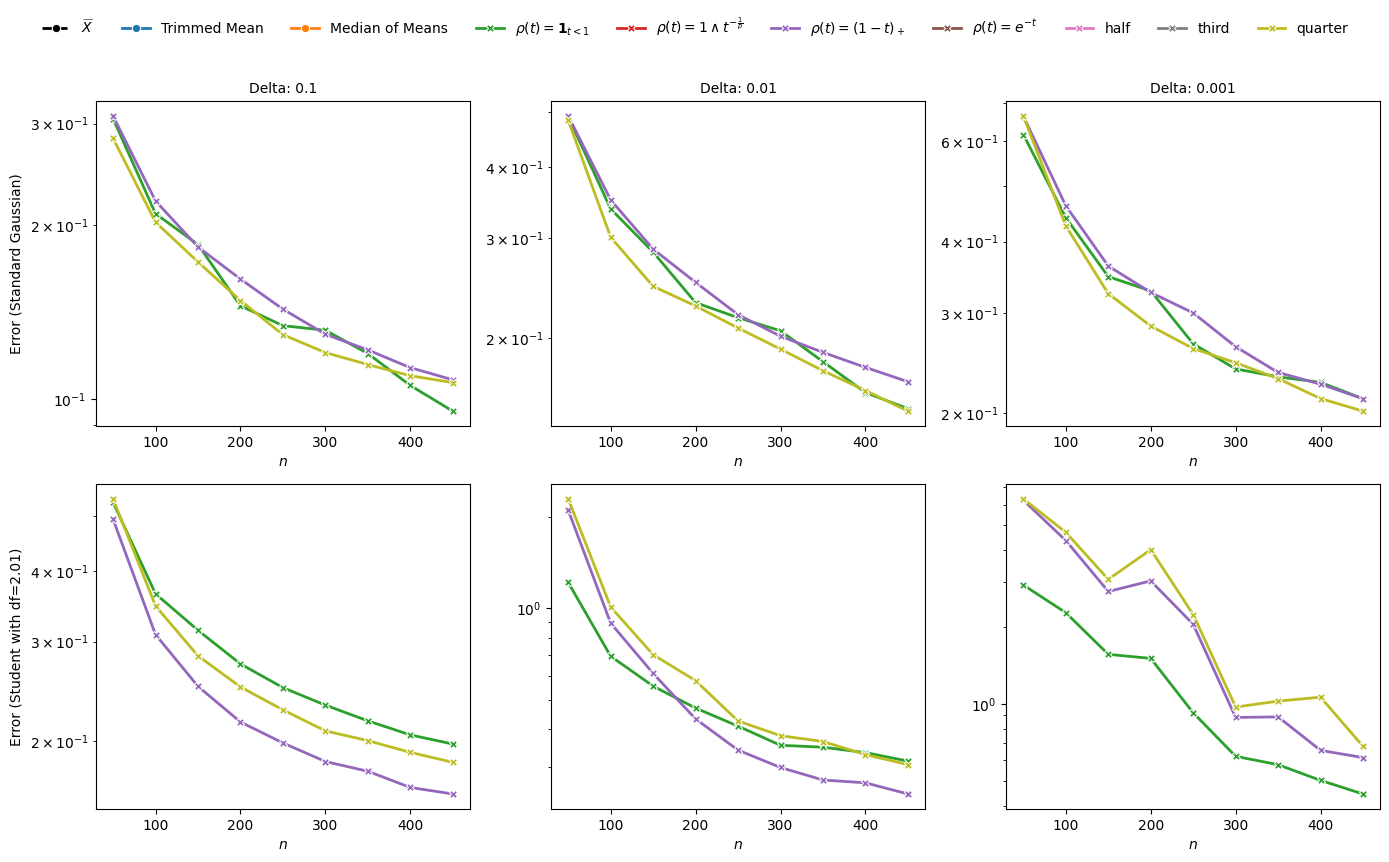

In [19]:
method_styles = {
    'mean': {'linestyle': '--', 'marker': 'o'},
    'tm': {'linestyle': '-', 'marker': 'o'},
    'mom': {'linestyle': '-', 'marker': 'o'},
    'atm': {'linestyle': '-', 'marker': 'X'},
    'win': {'linestyle': '-', 'marker': 'X'},
    'lv': {'linestyle': '-', 'marker': 'X'},
    'exp': {'linestyle': '-', 'marker': 'X'},
    'half': {'linestyle': '-', 'marker': 'X'},
    'third': {'linestyle': '-', 'marker': 'X'},
    'quarter': {'linestyle': '-', 'marker': 'X'},
}
method_order = [key for key in method_styles]
labels = [r"$\widebar{X}$", "Trimmed Mean", "Median of Means", r"$\rho(t) = \mathbf{1}_{t < 1}$",
          r"$\rho(t) = 1 \wedge t^{-\frac{1}{p}}$", r"$\rho(t) = (1-t)_+$", r"$\rho(t) = e^{-t}$", "half", "third", "quarter"]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for j, dist in enumerate(range_distributions):    
    for i, delta in enumerate(range_deltas):
        ax = axes[j][i]
        for method in method_order:
            subset = df_grouped[(df_grouped['distribution'] == dist) & (df_grouped['delta'] == delta) & (df_grouped['method'] == method)]
            if method == "mean":
                sns.lineplot(data=subset, x='n', y='error', ax=ax, lw=2, label=method, color="black",
                                linestyle=method_styles[method]['linestyle'], marker=method_styles[method]['marker'])
            else:
                sns.lineplot(data=subset, x='n', y='error', ax=ax, lw=2, label=method,
                                linestyle=method_styles[method]['linestyle'], marker=method_styles[method]['marker'])
        if j == 0:
            ax.set_title(f'Delta: {delta}', fontsize=10)
        ax.set_xlabel(r'$n$')
        ax.set_yscale("log")
        if i == 0:
            if j == 0:
                ax.set_ylabel('Error (Standard Gaussian)')
            else:
                ax.set_ylabel('Error (Student with df=2.01)')
        else:
            ax.set_ylabel('')
        
handles, _ = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor = (0, .08, 1, 1), frameon=False)

for ax in axes.flatten():
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig("improving.pdf", bbox_inches = 'tight', pad_inches = 0)